In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz

## Lendo e filtrando os dados coletados da API

In [2]:
df = pd.read_csv('ModoAPI_Data.csv')

In [3]:
#Limpando dados
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df[df['CarID'] != 'CarID']
df.dropna(how='any', axis=0, inplace=True)

In [4]:
# Formatando os dados para tipos mais apropriados
types = {
    'LocationID': int,
    'CarID': int,
    'FullyAvailable': float,
    'PartlyAvailable': float,
    'NotAvailable': float,
    'StartTime': str,
    'EndTime': str,
    'Duration': str,
    'RequestStart': int,
    'RequestEnd': int,
    'RequestDuration': int    
}

df = df.astype(dtype=types)
df['CaptureTime'] = pd.to_datetime(df['CaptureTime'])

df.drop(['LocationID', 'FullyAvailable', 'PartlyAvailable', 'NotAvailable',
         'Duration', 'EndTime', 'RequestEnd', 'RequestDuration'], axis=1, inplace=True)

# Coletando os IDs dos carros
car_ids = []
for i in range(len(df)):
    if (df['CarID'].iloc[i] in car_ids):
        continue
    else:
        car_ids.append(df['CarID'].iloc[i])

df.drop('CarID', axis=1, inplace=True)

# Retirando todos com o atributo start time == False (estão parados)
df = df[df['StartTime'] != 'False']

## Porcentagem de carros ocupados a cada minuto

In [5]:
# Converte hora dada a time zone atual, a zona a ser convertida e a diferença de tempo
def convert_datetime_timezone(dt, tz1, tz2, str_diff):
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)

    dt = datetime.datetime.fromtimestamp(dt)
    dt = datetime.datetime.strptime(str(dt),"%Y-%m-%d %H:%M:%S")
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    try:
        dt = datetime.datetime.strptime(str(dt),"%Y-%m-%d %H:%M:%S"+str_diff)
    # Except para evitar um erro pela mudança de fuso horário
    except Exception as e:
        print(e)
        # Diminui 1 hora para se adaptar
        dt = dt - datetime.timedelta(hours=1)
        dt = datetime.datetime.strptime(str(dt),"%Y-%m-%d %H:%M:%S"+'-08:00')
    
    dt = int(dt.timestamp())

    return dt

In [ ]:
in_travel = 0
andando_weekdays = []
andando_weekends = []

# Percorre todo o dataframe para verificar quais carros estão andando em dado minuto
for i in range(1, len(df)):
    capture_time_atual = int(df['CaptureTime'].iloc[i].timestamp())
    capture_time_atual = convert_datetime_timezone(capture_time_atual, 'UTC', 'America/Vancouver', '-07:00')

    capture_time_anterior = int(df['CaptureTime'].iloc[i-1].timestamp())
    capture_time_anterior = convert_datetime_timezone(capture_time_anterior, 'UTC', 'America/Vancouver', '-07:00')

    start_time = int(df['StartTime'].iloc[i])
    start_time = convert_datetime_timezone(start_time, 'America/Sao_Paulo', 'America/Vancouver','-07:00')

    request_start = df['RequestStart'].iloc[i]
    request_start = convert_datetime_timezone(request_start, 'America/Sao_Paulo', 'America/Vancouver','-07:00')

    # Enquanto está no mesmo minuto, é analisado se o carro está andando
    if (capture_time_atual == capture_time_anterior):
        if (start_time > request_start):
            in_travel += 1
    else:
        porcentagem = (in_travel/len(car_ids))*100
        
        # Verifica que a data está entre segunda(1) e sexta(5)
        if (int(datetime.datetime.fromtimestamp(capture_time_anterior).strftime('%w')) > 0 and int(datetime.datetime.fromtimestamp(capture_time_anterior).strftime('%w')) < 6):
            andando_weekdays.append([capture_time_anterior, in_travel, porcentagem])
        else:
            andando_weekends.append([capture_time_anterior, in_travel, porcentagem])
        in_travel = 0
        
dfIn_Travel_weekdays = pd.DataFrame(andando_weekdays, columns=['capture_time', 'total_in_travel', 'percentage'])
dfIn_Travel_weekends = pd.DataFrame(andando_weekends, columns=['capture_time', 'total_in_travel', 'percentage'])

In [ ]:
# Formatando os dados de unix timestamp para datetime

dfWeekdays = dfIn_Travel_weekdays
for i in range(len(dfWeekdays)):
    dfWeekdays['capture_time'].iloc[i] = datetime.datetime.fromtimestamp(dfWeekdays['capture_time'].iloc[i])
    
    
dfWeekends = dfIn_Travel_weekends
for i in range(len(dfWeekends)):
    dfWeekends['capture_time'].iloc[i] = datetime.datetime.fromtimestamp(dfWeekends['capture_time'].iloc[i])

In [10]:
dfWeekdays = pd.read_csv('weekdays.csv', usecols=[1,2,3])
dfWeekends = pd.read_csv('weekends.csv', usecols=[1,2,3])

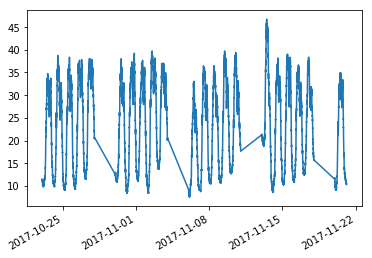

In [5]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfWeekdays['capture_time'],dfWeekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

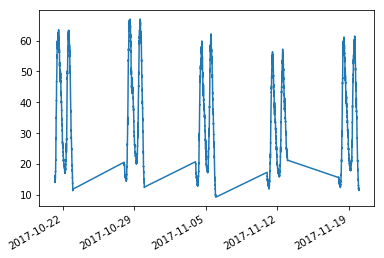

In [14]:
# Plot da porcentagem de carros alocados em dias de final de semana
plt.plot(dfWeekends['capture_time'],dfWeekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

## Porcentagem média de carros ocupados em cada minuto

In [14]:
# Faz a media das porcentagens para todos os minutos de uma certa quantidade de dias
def media(df, num_dias):
    media = []
    um_dia = 1440
    ant = -1
    valores = pd.DataFrame()
    # Loop que irá verificar um dia de registros(24h = 1440 min) visualizando cada minuto
    for i in range(um_dia-1):

        # Irá percorrer os dias seguintes para encontrar as outras incidencias do mesmo minuto
        for j in range(i, num_dias * um_dia, um_dia-80):       

            try:
                # Por conta de filtros os indices não estão exatos
                # Ele irá procurar em um intervalo o minuto desejado
                for c in range(j, j+3000):
                    #Se tiver o mesma hora e minuto somamos a média, além de ser diferente do valor anterior
                    if (df['datetime'].iloc[c].minute == df['datetime'].iloc[i].minute and 
                        df['datetime'].iloc[c].hour == df['datetime'].iloc[i].hour and
                        int(df['datetime'].iloc[c].day) != ant):
                        
                        valores = valores.append([df['percentage'].iloc[c]])
                        
                        #variavel para evitar pegar valores repetidos
                        ant = int(df['datetime'].iloc[c].day)
                        
                        # Atualiza o j para onde o minuto foi encontrado
                        j=c
                        break
            
            except Exception as e:
                print(e)
                break
        
        # Registra somente a hora, media e desvio padrão das porcentagens dos dias
        media.append([df['datetime'].iloc[i].strftime('%H:%M'), float(valores.mean()), float(valores.std())])
        valores = pd.DataFrame()

    media = pd.DataFrame(media, columns=['time', 'mean', 'std'])
    
    # Formatando a hora para datetime
    for i in range(len(media)):
        media['time'].iloc[i] = datetime.datetime.strptime(media['time'].iloc[i], '%H:%M').time()
    
    return media

In [ ]:
# Fazendo a média das porcentagens de cada dia
dfWeekdays = dfWeekdays.sort_values(by='capture_time')
mediaWeekdays = media(dfWeekdays, 23)

dfWeekends = dfWeekends.sort_values(by='capture_time')
mediaWeekends = media(dfWeekends, 10)

In [6]:
# Ordenando pelo tempo
mediaWeekdays = mediaWeekdays.sort_values(by=['time'])
mediaWeekends = mediaWeekends.sort_values(by=['time'])

# Gráficos de porcentagem média de carros ocupados em cada minuto

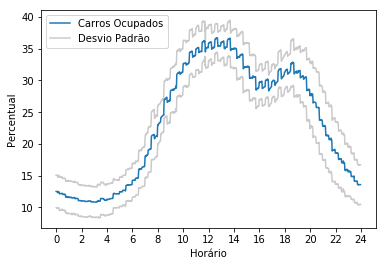

In [7]:
import numpy as np

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
plt.savefig('Weekdays.pdf', bbox_inches='tight')

plt.show()

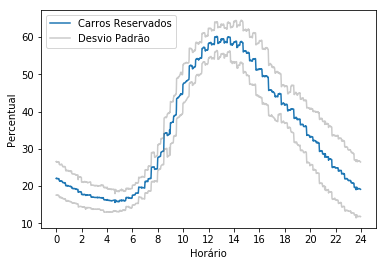

In [8]:
import numpy as np

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Reservados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
plt.savefig('Weekends.pdf', bbox_inches='tight')

plt.show()

## Extração das porcentagens de carros reservados

In [ ]:
# CSV criado a partir dos dados coletados do arquivo ModoApi_Data_Filter
dfTravels = pd.read_csv('Travels.csv', usecols=[1,2,3,4])

In [48]:
# Concatenando reservas consecutivas
# Opcional

for i in range(len(dfTravels)):
    try:
        if (dfTravels['only_new_reserves'].iloc[i]):
            for j in range(i+1, len(dfTravels)):
                if (dfTravels['only_new_reserves'].iloc[j] and j > i):
                    dfTravels['end'].iloc[i] = dfTravels['end'].iloc[j-1]
                    dfTravels = dfTravels.drop(dfTravels.index[i+1:j])
                    break
    except:
        break
dfTravels.index = range(len(dfTravels))
dfTravels.to_csv('travels_concat.csv')

,car_id,start,end,only_new_reserves
0,528,1508782515,1508795100,True
1,528,1508786779,1508796900,False
2,528,1508933746,1508952600,True
3,528,1508943350,1508953500,False
4,528,1509278419,1509303600,True
5,528,1509295286,1509309000,False
6,528,1509295346,1509309900,False
7,528,1509372007,1509402600,True
8,528,1509381192,1509403500,False
9,528,1509437687,1509473700,True


In [7]:
# Função para contar a porcentagem de carros reservados nos dias passados como parâmetro
# A função deve receber os valores previamente separados como somente dias de semana ou finais de semana
def cont_reservas(dfDays):
    # Coletando todos os minutos de captura
    datas = pd.to_datetime(dfDays['capture_time'])
    datas = pd.DataFrame(datas)

    dfReservas = pd.concat([dfTravels['start'], dfTravels['end']], axis=1)
    dfReservas = dfReservas.sort_values(by='start')

    cont_reservas = 0
    reservas = []

    for i in range(len(datas)):
        data_timestamp = datas['capture_time'].iloc[i].timestamp()

        # Comparando todas as datas aos  intervalos das reservas, e vendo se ele faz parte para se somar a porcentagem
        for j in range(len(dfReservas)):
            if (dfReservas['start'].iloc[j] <= data_timestamp and data_timestamp <= dfReservas['end'].iloc[j]):
                cont_reservas += 1

        porcentagem = (cont_reservas/len(car_ids))*100

        # Verifica que a data está entre segunda(1) e sexta(5)

        data = datas['capture_time'].iloc[i]

        reservas.append([data, cont_reservas, porcentagem])

        cont_reservas = 0

    reservas = pd.DataFrame(reservas, columns=['datetime', 'total_reserves', 'percentage'])

    return reservas

In [40]:
dfR_Weekdays = cont_reservas(dfWeekdays)
dfR_Weekends = cont_reservas(dfWeekends)

In [10]:
# Formatando os dias para datetime
dfR_Weekdays['datetime'] = pd.to_datetime(dfR_Weekdays['datetime'])
dfR_Weekends['datetime'] = pd.to_datetime(dfR_Weekends['datetime'])

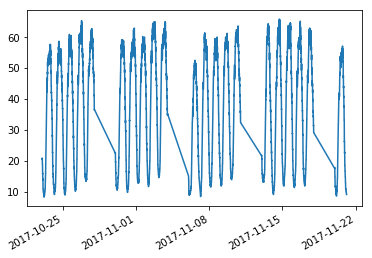

In [11]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfR_Weekdays['datetime'],dfR_Weekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

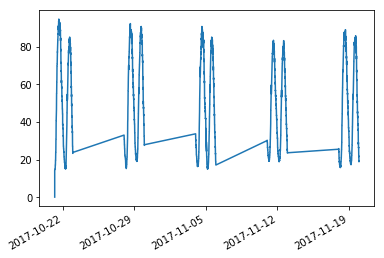

In [12]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfR_Weekends['datetime'],dfR_Weekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Fazendo a média das porcentagens de cada dia
dfR_Weekdays = dfR_Weekdays.sort_values(by='datetime')
dfmediaR_Weekdays = media(dfR_Weekdays, 23)

dfR_Weekends = dfR_Weekends.sort_values(by='datetime')
dfmediaR_Weekends = media(dfR_Weekends, 10)

# Plotagem final da porcentagem de carros reservados e ocupados

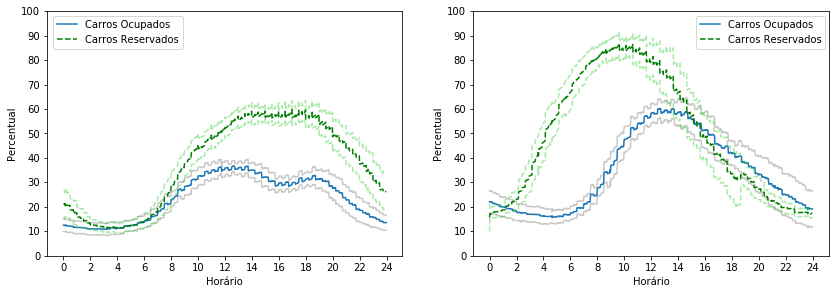

In [45]:
import numpy as np

# Plot das porcentagens dos fins de semana
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(14,4.5)




# Curva dos carros andando
ax1.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray')
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')


# Curva dos carros reservados
ax1.plot(range(len(dfmediaR_Weekdays['time'])),dfmediaR_Weekdays['mean'], label='Carros Reservados', c='g', ls='--')

# Curvas representando o intervalo de desvio padrão
ax1.plot(range(len(dfmediaR_Weekdays['time'])), dfmediaR_Weekdays['mean']+dfmediaR_Weekdays['std'], alpha=150, c='#32CD32', ls='--')
ax1.plot(range(len(dfmediaR_Weekdays['time'])), dfmediaR_Weekdays['mean']-dfmediaR_Weekdays['std'], alpha=150, c='#32CD32', ls='--')


# Modificando os labels das horas e das porcentagens
ax1.xaxis.set_ticks(np.arange(0, 1441, 120))
ax1.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,26,2)

ax1.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax1.set_ylim([0,100])

# Legendas e label dos eixos
ax1.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
ax1.set_ylabel('Percentual')
ax1.set_xlabel('Horário')




# Curva dos carros andando
ax2.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray')
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')


# Curva dos carros reservados
ax2.plot(range(len(dfmediaR_Weekends['time'])),dfmediaR_Weekends['mean'], label='Carros Reservados', c='g', ls='--')

# Curvas representando o intervalo de desvio padrão
ax2.plot(range(len(dfmediaR_Weekends['time'])), dfmediaR_Weekends['mean']+dfmediaR_Weekends['std'], alpha=150, c='#32CD32', ls='--')
ax2.plot(range(len(dfmediaR_Weekends['time'])), dfmediaR_Weekends['mean']-dfmediaR_Weekends['std'], alpha=150, c='#32CD32', ls='--')

# Modificando os labels das horas e das porcentagens
ax2.xaxis.set_ticks(np.arange(0, 1441, 120))
ax2.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,26,2)

ax2.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax2.set_ylim([0,100])

# Legendas e label dos eixos
ax2.legend(bbox_to_anchor=(0.62, 0.99), loc=2, borderaxespad=0.2)
ax2.set_ylabel('Percentual')
ax2.set_xlabel('Horário')



plt.savefig('ViagensPorHoras.pdf')